# Introduction

KAGGLE-LIKE CHALLENGE

Créer le meilleur modèle pour prédire des conversions en fonction des paramètres disponibles. Les modèles seront évalués à l'aide du f1-score.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="SOMMAIRE")

# I. LIBRARIES & FUNCTIONS

In [2]:
### LIBRARIES ###

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


### FUNCTIONS ###

def num_cat_index(X) :
    """
    Function to differentiate numerical from categorical columns.
    Return 2 lists : 
       - num_index : numerical column index
       - cat_index : categorical column index
    """
    
    idx = 0
    num_features = []
    num_index = []
    cat_features = []
    cat_index = []
    
    for col, col_type in X.dtypes.iteritems() :
        if  ('float' in str(col_type)) or ('int' in str(col_type)) :
            num_features.append(col)
            num_index.append(idx)
        else :
            cat_features.append(col)
            cat_index.append(idx)
        idx = idx + 1

    print('Numeric features :', num_features,"\nNumeric features' index :", num_index)
    print('Categorical features :', cat_features,"\nCategorical features' index :", cat_index)    
    return num_index, cat_index

# II. INITIAL DATASET (with label)

## Loading

In [3]:
data = pd.read_csv('conversion_data_train.csv')
print('labeled dataset shape :', data.shape)

labeled dataset shape : (284580, 6)


## Quick Exploration

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [6]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


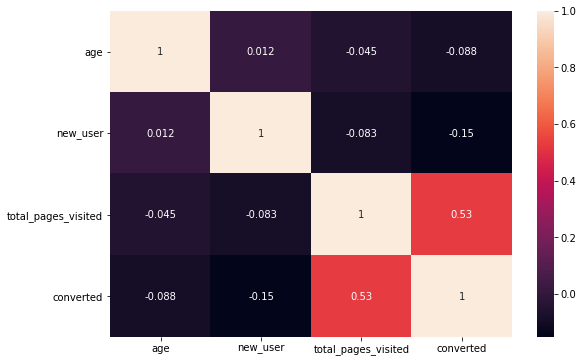

In [7]:
# Correlation matrix :
corr = data.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, ax=ax)

## Comments
On constate que le paramètre 'total_pages_visited' est particulièrement corrélé à la conversion.

Les autres paramètres sont peu corrélés à la conversion.

# III. FEATURES ENGINEERING

## Outliers management

In [8]:
# Deleting outliers = age > 100 :
data = data[data['age']<100]

## Columns' multiplication

### Creating columns

In [9]:
data['tpv_square'] = data['total_pages_visited']**2
data['tpv_cube'] = data['total_pages_visited']**3
data['age_square'] = data['age']**2
data['age_cube'] = data['age']**3
data['age_visit'] = data['total_pages_visited']*data['age']

### Checking correlation

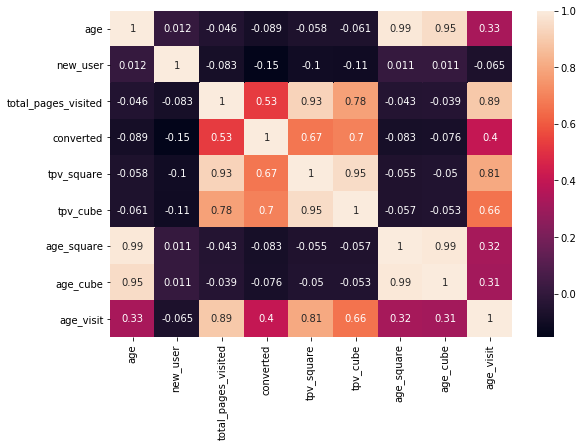

In [10]:
# Correlation matrix :
corr = data.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, ax=ax)

### Comments :
 - 'tpv_square' est trop corrélé à 'total_page_visited',
 - 'age_square' et 'age_cube' sont trop corrélés à 'age',
 - 'age_visit' est trop corrélé à 'total_page_visited'.
 
 Nous retirons ces features.

### Droping unnecessary columns

In [11]:
data = data.drop(columns=['tpv_square', 'age_square', 'age_cube', 'age_visit'])

# IV. FEATURES SELECTION

## Features selection

In [12]:
# Définition de la variable cible et des variables explicatives :
target_variable = 'converted'
features_list = list(data.columns.drop(target_variable))
print("Features :\n", features_list)

Features :
 ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'tpv_cube']


In [13]:
# Séparation des variables explicatives de type numérique et catégorique :
num_index, cat_index = num_cat_index(data[features_list])

Numeric features : ['age', 'new_user', 'total_pages_visited', 'tpv_cube'] 
Numeric features' index : [1, 2, 4, 5]
Categorical features : ['country', 'source'] 
Categorical features' index : [0, 3]


## Variables definition

In [14]:
X = data[features_list]
Y = data[target_variable]

# V. PREDICTION MODEL

## Train set / Test set definition

In [15]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [16]:
# On convertie les Pandas DataFrame en Numpy Arrays avant d'utiliser Scikit-Learn :
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

Convert pandas DataFrames to numpy arrays...
...Done


## Training pipeline

### Encoding & Standardizing features

In [17]:
# On encode les variables catégoriques et on normalise les variables numériques :
print("Encoding categorical features and standardizing numerical features on train set...\n")
print(X_train[0:3,:])

# Normalisation :
numeric_transformer = StandardScaler()

# OneHotEncoder : / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

# Encoder :
featureencoder = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_index),    
    ('num', numeric_transformer, num_index)])

X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:3,:])

Encoding categorical features and standardizing numerical features on train set...

[['US' 18 0 'Seo' 4 64]
 ['China' 49 0 'Seo' 5 125]
 ['China' 46 1 'Seo' 3 27]]
...Done
[[ 0.          0.          1.          0.          1.         -1.51987065
  -1.47678829 -0.26099836 -0.2986172 ]
 [ 0.          0.          0.          0.          1.          2.2307148
  -1.47678829  0.03829244 -0.23080194]
 [ 0.          0.          0.          0.          1.          1.86775492
   0.67714513 -0.56028917 -0.33975105]]


### Model selection : LogisticRegressionCV

In [18]:
classifier = LogisticRegression()

### Model training

In [19]:
print("Train model...")
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


### Prediction on training set

In [20]:
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")

Predictions on training set...
...Done.


## Test pipeline

### Encoding & Standardizing features

In [21]:
print("Encoding categorical features and standardizing numerical features on test set...\n")
print(X_test[0:3,:])
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:3,:])

Encoding categorical features and standardizing numerical features on test set...

[['China' 24 1 'Ads' 14 2744]
 ['US' 35 0 'Direct' 5 125]
 ['US' 29 0 'Direct' 4 64]]
...Done
[[ 0.          0.          0.          0.          0.         -0.79395089
   0.67714513  2.73190968  2.68080726]
 [ 0.          0.          1.          1.          0.          0.53690202
  -1.47678829  0.03829244 -0.23080194]
 [ 0.          0.          1.          1.          0.         -0.18901775
  -1.47678829 -0.26099836 -0.2986172 ]]


### Prediction on test set

In [22]:
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")

Predictions on test set...
...Done.


## Performance assessment

### F1-Score

In [23]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7627482555018786
f1-score on test set :  0.7711711711711712


### Confusion matrix

In [24]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))

Confusion matrix on train set : 
[[246900    960]
 [  2576   5684]]

Confusion matrix on test set : 
[[27435   105]
 [  276   642]]


## Re-Training final model on all labeled dataset

In [25]:
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# VI. PREDICTION ON NEW DATASET (without labels)

## Loading dataset

In [26]:
# Loading dataset without labels :
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('dataset without labels :', data_without_labels.shape)

dataset without labels : (31620, 5)


## Pipeline

In [27]:
# Features engineering :
data_without_labels['tpv_cube'] = data_without_labels['total_pages_visited']**3


# Variables definition :
X_without_labels = data_without_labels[features_list]


# Convert pandas DataFrames to numpy arrays before using scikit-learn
X_without_labels = X_without_labels.values


# Encoding & Standardizing features
X_without_labels = featureencoder.transform(X_without_labels)


print(X_without_labels[0:3,:])

[[ 0.          1.          0.          0.          1.         -0.31000438
  -1.47678829  3.33049128  4.18386019]
 [ 0.          1.          0.          1.          0.         -1.03592414
   0.67714513  0.03829244 -0.23080194]
 [ 0.          0.          0.          0.          1.          0.17394213
   0.67714513 -1.15887077 -0.36865591]]


## Predictions & results extraction

In [28]:
### NOTES ###
    # MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
    # FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
    # where [name] is the name of your team/model separated by a '-' (for example : [name] = AURELIE-baseline)
### NOTES ### 


# Making predictions :
Y_prediction = pd.DataFrame(columns=['converted'],data={'converted': classifier.predict(X_without_labels)})


# Dumping to file :
Y_prediction.to_csv('conversion_data_test_predictions_Ulysse-final.csv', index=False)